In [53]:
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)    

In [2]:
from metaflow import Flow
flow = Flow('PreprocessPaginate').latest_successful_run
raw_df = flow.data.pages_df

In [6]:
raw_df.groupby('userId').agg('count').sort_values('pageId')

,time,eltime,bookId,unknownWords,words,wpm,session,cheat,pageId,word,signal,itemsJson,knownWords
userId,,,,,,,,,,,,,
u9C0uSg83VGUJdRLKwM6,1,1,1,1,1,1,1,1,1,1,1,1,1
GKJVv47Xyo0p9bAFglZG,1,1,1,1,1,1,1,1,1,1,1,1,1
diFizsCHQ3um6xH7rWwb,1,1,1,1,1,1,1,1,1,1,1,1,1
vziGmu3KIAgMrMDHEPEZ,2,2,2,2,2,2,2,2,2,2,2,2,2
pvdmoG5grlq95LLXcGaz,2,2,2,2,2,2,2,2,2,2,2,2,2
FWp4npFjtaREu4KnLdNq,2,2,2,2,2,2,2,2,2,2,2,2,2
UpifsWKmy7kckaKo5VrG,2,2,2,2,2,2,2,2,2,2,2,2,2
A4arcbjZqnDXTFHU8zfv,2,2,2,2,2,2,2,2,2,2,2,2,2
WrYdwVUTTEN6aUFhH256,2,2,2,2,2,2,2,2,2,2,2,2,2


In [364]:
df = raw_df.copy()

In [365]:
nouse_vec = 3
estimators = 50
k = 30

In [366]:
def score(df):
    out = 0
    clusters = df['cluster'].unique()
    for cluster in clusters:
        out += df.loc[df['cluster'] == cluster]['signal'].std()
    return out / len(clusters)

In [457]:
import xgboost as xgb
import pandas as pd
from sklearn.cluster import MeanShift, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

words = raw_df['word'].unique()
vector_list = [model[word] for word in words if word in model.vocab]
words_filtered = [word for word in words if word in model.vocab]
word_vec_zip = zip(words_filtered, vector_list)
word_vec_dict = dict(word_vec_zip)
df2 = pd.DataFrame.from_dict(word_vec_dict, orient='index')

df = raw_df.copy().groupby('word').agg({'signal': 'mean'})
df = df.join(df2, how='right').reset_index().rename(columns={'index': 'word'})
del df['word']
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(df.iloc[:, df.columns!='signal'])
result = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300).fit_transform(pca_result_50)
x = pd.DataFrame(result)

y = df['signal']

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1591 samples in 0.002s...
[t-SNE] Computed neighbors for 1591 samples in 0.175s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1591
[t-SNE] Computed conditional probabilities for sample 1591 / 1591
[t-SNE] Mean sigma: 0.667852
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.099297
[t-SNE] KL divergence after 300 iterations: 2.191145


In [458]:
def classify(x):
    if x <= 0.2:
        return 0
    if x <= 0.4:
        return 1
    if x <= 0.6:
        return 2
    if x <= 0.8:
        return 3
    return 4
y = y.map(classify)
y = keras.utils.to_categorical(y)

In [459]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [460]:
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()

In [479]:
from sklearn import datasets, linear_model
from sklearn import metrics
from sklearn.model_selection import cross_val_score, KFold
from tensorflow.keras.models import Sequential
from tensorflow import keras
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
seed = 1


def baseline_model():
    model = Sequential()
    model.add(Dense(32, input_dim=2, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model


estimator = KerasClassifier(build_fn=baseline_model, nb_epoch=1000, batch_size=16, verbose=False)
# kfold = KFold(n_splits=8, random_state=seed)
# results = cross_val_score(estimator, x_train, y_train, cv=kfold)
# print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

estimator.fit(x_train, y_train)
prediction = estimator.predict(x_test)
print(metrics.classification_report(np.argmax(y_test, axis=-1), prediction, digits=3))



              precision    recall  f1-score   support

           0      0.000     0.000     0.000       100
           1      0.000     0.000     0.000        10
           2      0.115     0.075     0.091        40
           3      0.333     0.029     0.053        35
           4      0.403     0.873     0.552       134

    accuracy                          0.379       319
   macro avg      0.170     0.195     0.139       319
weighted avg      0.221     0.379     0.249       319



/Users/sunho/anaconda3/envs/dataserver/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [480]:
inter_output_model = keras.Model(estimator.model.input, estimator.model.get_layer(index = 0).output )

In [483]:
y_df = pd.DataFrame(np.argmax(y_test, axis=-1))
x_df = pd.DataFrame(inter_output_model.predict(x_test))
y_df.columns = ['signal']
kmeans = KMeans(n_clusters=10).fit(x_df)
y_df['cluster'] = kmeans.predict(x_df)
score(y_df)

1.7367509620250643

In [467]:
x_df.columns = ['x','y']
cluser_df = x_df.join(y_df)

ValueError: Length mismatch: Expected axis has 32 elements, new values have 2 elements

In [468]:
cluser_df

,x,y,signal,cluster
0,0.393195,0.231360,4,4
1,0.031686,0.241060,0,1
2,-0.085786,-0.247195,4,3
3,0.820000,0.013294,3,0
4,-0.042191,0.163797,4,1
...,...,...,...,...
314,0.824722,0.046843,0,0
315,0.491179,0.076497,3,4
316,0.720108,-0.428234,0,2
317,0.311771,-0.094559,4,3


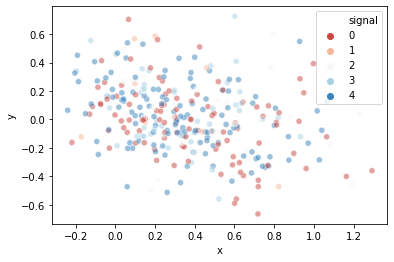

In [437]:
import seaborn as sns
sns.scatterplot(
    x="x", y="y",
    hue="signal",
    data=cluser_df,
    palette=sns.color_palette("RdBu", n_colors=5),
    alpha=0.5
)